# Part 3: Model Selection and Evaluation

#### Concepts Covered
Part 3 covers preprocessing, modeling using multiple classifiers, modeling evaluation using Yellowbrick's classification reports, confusion matrix, hyper-parameter tuning, and model output.

#### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

#Preprocessing and Feature Selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Classificatoin Models and Metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#YellowBrick Visualizers
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC

#Export Fitted Data
import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Preprocesisng

*Import*

In [2]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')

wng_fmly_df = pd.read_sql('''select * from final_family_data''', conn)

conn.close()

*Subset*

In [3]:
columns = ['income_class','inc_class_encode','NO_EARNR','AGE_REF','MARITAL1','AS_COMP1','CUTENURE',
           'FAM_SIZE','FAM_TYPE','HIGH_EDU','VEHQ','INC_HRSQ']

wng_fmly_df = wng_fmly_df[columns]

In [4]:
feature_list = columns[2:]
target_list = columns[1]

X = wng_fmly_df[feature_list]
y = wng_fmly_df[target_list]

*Train-Test-Split and Scale*

Standardize data *after* splitting into test and training data. Otherwise, you run the risk of leaking information since technically data your model should not be aware of was used in the scaling of your training dataset.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
scaler = StandardScaler()

X_train_fit = scaler.fit(X_train)
X_test_fit = scaler.fit(X_test)

X_train_scale = X_train_fit.transform(X_train)
X_test_scale = X_test_fit.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


## Modeling

#### Models

*Primary*:
- Random Forest Classifier
- Gradient Boosting Classifier
- K-Nearest Neighbors Classifier

*Secondary*:
- Decision Tree Classifier
- Extra Tree Classifier
- Bagging Classifier with Decision Tree Classifier Estimator (Default value)
- Bagging Classifier with Random Forest Classifier Estimator

#### Notes:
- I should have considered splitting the data into more classes, using upsampling to address any persistent class imbalance.
- As suggested by accuracy before and after tuning the GBC showed the best results.
- All models had classification reports that suggested it was *more* difficult to accurately distinguish households with at least 70K than those with less than 70K.
- Confusion Matrix with only two classes does not tell us anything more that the classification report did not.

In [7]:
models_list = [
    ['GradientBoosting',GradientBoostingClassifier()],
    ['RandomForestClassifier',RandomForestClassifier()],
    ['KNN',KNeighborsClassifier()],
]

In [8]:
models_dict = {}

for name, model in models_list:
    try:
        fit = model.fit(X_train_scale, y_train)

        models_dict[name] = fit
        
        print("{} fitted".format(name))

    except Exception as e:
        print("{} failed; {}.".format(name, e))

GradientBoosting fitted
RandomForestClassifier fitted
KNN fitted


In [9]:
for name, model in models_dict.items():
    print(name, ":", accuracy_score(y_test, model.predict(X_test_scale)))

GradientBoosting : 0.8288135593220339
RandomForestClassifier : 0.8076271186440678
KNN : 0.8059322033898305


#### Classification Reports

Gradient Boosting had the highest overall accuracy, followed by Random Forest. The classification reports are confirm what the RadViz chart suggested in our earlier notebook on this project: All models have a hard time distinguishing between the classes. The classification reports also suggest that models performed similarly, having a harder time classifying those households with at least 70K accurately than households with less than. More specifically, the Precision score for the Gradient Boosting Classifier shows the ability to correctly label households as making at least 70K in the last 12 months relative to all the predictions made is 77%.

In [10]:
# 1: >=70k, 0: <70k
classes = ["<70k", ">=70k"]

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


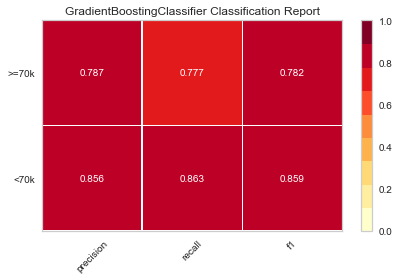

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


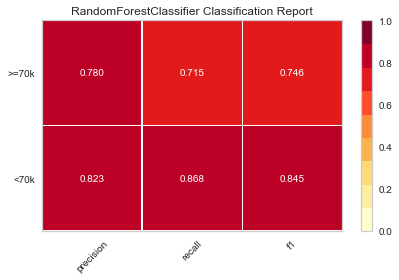

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


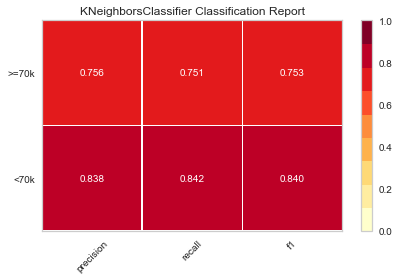

In [11]:
for name, model in models_dict.items():
    cr = ClassificationReport(model, classes=classes)
    cr.score(X_test_scale, y_test)
    cr.poof()

#### Confusion Matrix

The confusion matrices simply reiterates the results of the classification reports.

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


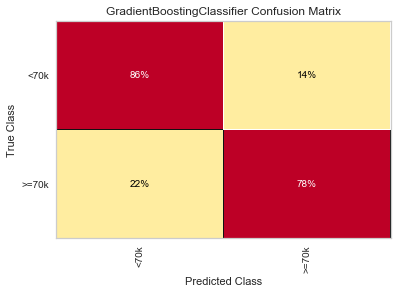

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


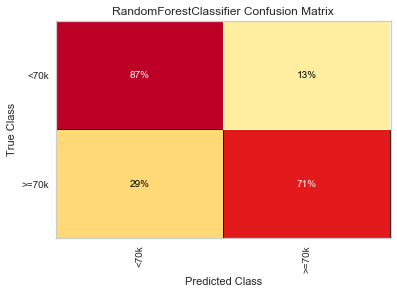

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


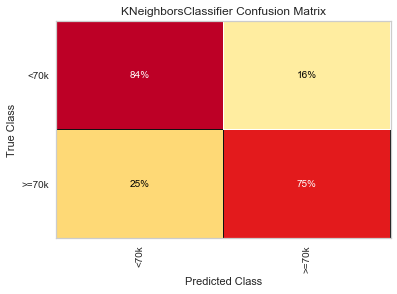

In [12]:
for name, model in models_dict.items():
    cm = ConfusionMatrix(model, percent=True, classes=classes)
    cm.score(X_test_scale, y_test)
    cm.poof()

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


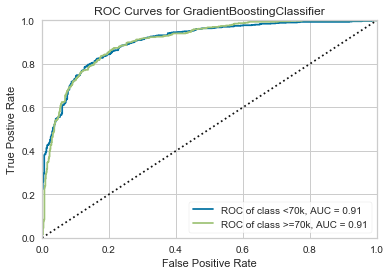

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


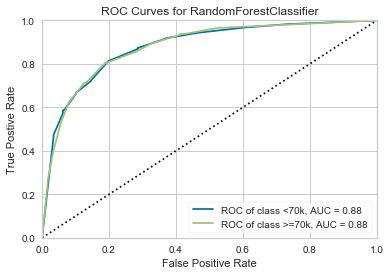

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


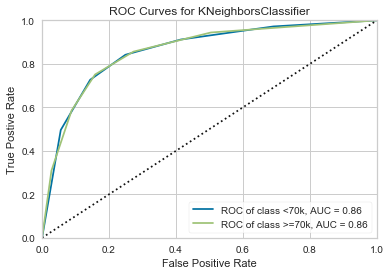

In [13]:
for name, model in models_dict.items():
    prc = ROCAUC(model, classes=classes, micro=False, macro=False)
    prc.score(X_test_scale, y_test)
    prc.poof()

### Hyper-parameter Tuning

A naive hyper-parameter tuning exercise is to tune our classifiers to optimize various metrics. I call it naive because I picked the parameters randomly as a thought exercise (would fit well in a pipeline).

In [14]:
model_params = [{'name':'GBC',
                 'model':GradientBoostingClassifier(),
                 'parameters':{'learning_rate':[0.1, 0.2, 0.3, 0.01],
                               'n_estimators':[1, 10, 50, 100, 300, 500]}},
                {'name':'RFC',
                 'model':RandomForestClassifier(),
                 'parameters':{'max_depth':[1, 10, 50],
                               'n_estimators':[1, 10, 50, 100, 300, 500]}},
                {'name':'KNN',
                 'model':KNeighborsClassifier(),
                 'parameters':{'n_neighbors':[1, 3, 5, 7, 10, 50]}}]

In [15]:
for model in model_params:
    #Set
    grid_search = GridSearchCV(estimator=model['model'],
                           param_grid=model['parameters'],
                           scoring='accuracy',
                           cv=4,
                           n_jobs=-1,
                           verbose=10)
    
    #Train
    grid_search = grid_search.fit(X_train_scale, y_train)
    
    #Score
    score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    #Print
    print(model['name'], score, best_params)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   36.8s finished


GBC 0.8228438228438228 {'learning_rate': 0.1, 'n_estimators': 50}
Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0491s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   38.1s finished


RFC 0.821360457724094 {'max_depth': 10, 'n_estimators': 300}
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    4.2s remaining:    0.8s


KNN 0.809493536766264 {'n_neighbors': 50}


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    5.6s finished


### Model Output

Up to this point, we haven't been saving our model transformations, scaling, or design. For example, in Part 1, we encoded our target; Part 2, standardized our features; Part 3, determined our best model.

At minimum, we will be sure to output our hyper-parameterized Gradient Boosting Classifier model.

In [16]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)

In [17]:
gbc_fit = model.fit(X_train_scale, y_train)

In [18]:
print(accuracy_score(y_test, model.predict(X_test_scale)))

0.8296610169491525


In [19]:
joblib.dump(gbc_fit, '../model/gradient-classifier-fit.sav')

['../model/gradient-classifier-fit.sav']